In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import hdbscan
import umap
import copy

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score

mpl.rcParams['figure.dpi']= 500
sns.set_context("notebook")
sns.set(style="white")

In [2]:
cellvgae_umap = np.load('CellVGAE/cellvgae_umap.npy')
cellvgae_clusters = np.load('CellVGAE/cellvgae_clusters.npy')

In [3]:
sam_umap = np.load('SAM/sam_umap.npy')
sam_clusters = np.load('SAM/sam_clusters.npy')

In [4]:
diffvae_umap = np.load('DiffVAE/diffvae_umap.npy')
diffvae_clusters = np.load('DiffVAE/diffvae_clusters.npy')

In [5]:
cellvgae_umap.shape[0]

2638

<ipython-input-6-2d6213cb4497>:19: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f1bc9a820a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax1.legend(handletextpad=0.3, fontsize=5, loc='lower left', labels=['_nolegend_', 'B', 'FCGR3A Mono', 'NK', 'DC', 'CD14 Mono', 'CD8 T', 'CD4 T', 'Platelet'], frameon=False)
<ipython-input-6-2d6213cb4497>:24: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f1bc9a37bb0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax2.legend(handletextpad=0.3, fontsize=5, loc='lower left', labels=['_nolegend_', 'CD4 T', 'Mono, DC', 'B', 'NK, CD8 T', 'Platelet'], frameon=False)
<ipython-input-6-2d6213cb4497>:31: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f1bc9a5a4f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax3.legend(handletextpad=0.3, fontsize=7, loc='lower right', la

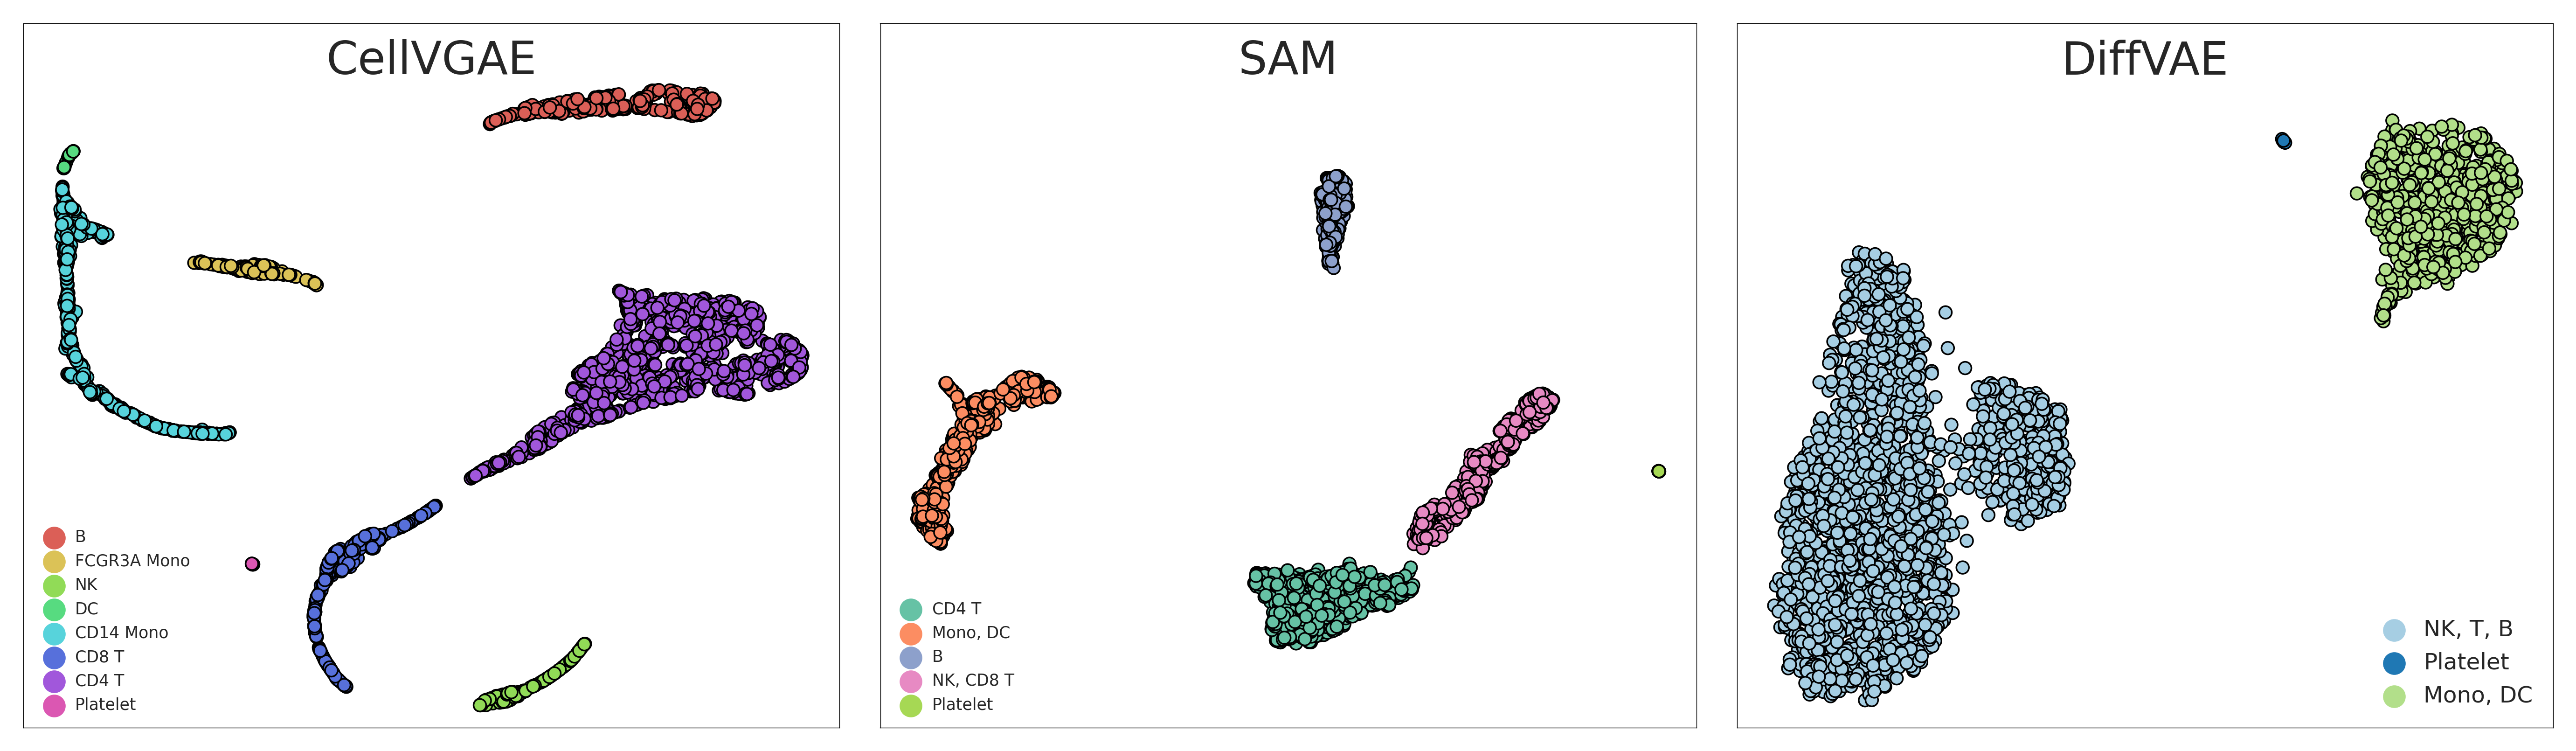

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sns.scatterplot(x=cellvgae_umap[:, 0], y=cellvgae_umap[:, 1], hue=cellvgae_clusters, palette=sns.color_palette("hls", len(set(cellvgae_clusters))), s=15, edgecolor='black', linewidth=0.5, ax=ax1)
sns.scatterplot(x=sam_umap[:, 0], y=sam_umap[:, 1], hue=sam_clusters, palette=sns.color_palette("Set2", len(set(sam_clusters))), s=15, edgecolor='black', linewidth=0.5, ax=ax2)
sns.scatterplot(x=diffvae_umap[:, 0], y=diffvae_umap[:, 1], hue=diffvae_clusters, palette=sns.color_palette("Paired", len(set(diffvae_clusters))), s=15, edgecolor='black', linewidth=0.5, ax=ax3)

plt.setp(ax1.spines.values(), color='black')
plt.setp(ax2.spines.values(), color='black')
plt.setp(ax3.spines.values(), color='black')

for ax in (ax1, ax2, ax3):
    ax.spines['left'].set_linewidth(0.2)
    ax.spines['top'].set_linewidth(0.2)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['right'].set_linewidth(0.2)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title("CellVGAE", position=(0.5, 0.9), fontdict={'fontsize': 14})
ax1.legend(handletextpad=0.3, fontsize=5, loc='lower left', labels=['_nolegend_', 'B', 'FCGR3A Mono', 'NK', 'DC', 'CD14 Mono', 'CD8 T', 'CD4 T', 'Platelet'], frameon=False)
plt.setp(ax1, ylim=(-10, 24))

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.legend(handletextpad=0.3, fontsize=5, loc='lower left', labels=['_nolegend_', 'CD4 T', 'Mono, DC', 'B', 'NK, CD8 T', 'Platelet'], frameon=False)
ax2.set_title("SAM", position=(0.5, 0.9), fontdict={'fontsize': 14})
plt.setp(ax2, ylim=(-10, 21))

ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title("DiffVAE", position=(0.5, 0.9), fontdict={'fontsize': 14})
ax3.legend(handletextpad=0.3, fontsize=7, loc='lower right', labels=['_nolegend_', 'NK, T, B', 'Platelet', 'Mono, DC'], frameon=False)
plt.setp(ax3, ylim=(-5, 3))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig('pbmc3k_plots.pdf', dpi=500, bbox_inches='tight')

In [7]:
def overlap_percent(vgae_list, sam_list):
    common = len([x for x in vgae_list if x in sam_list])
    return common, common / len(sam_list)

In [8]:
def get_cells_by_cluster(assignment_df, cluster_id):
    return assignment_df.loc[assignment_df['Cluster'] == cluster_id].index.values

In [9]:
gt_df = pd.read_csv('seurat_ground_truth.csv')

In [10]:
gt_df.set_index('Unnamed: 0', inplace=True)

In [11]:
cells = gt_df.index.values

In [12]:
cells

array(['AAACATACAACCAC', 'AAACATTGAGCTAC', 'AAACATTGATCAGC', ...,
       'TTTCTACTTCCTCG', 'TTTGCATGAGAGGC', 'TTTGCATGCCTCAC'], dtype=object)

In [13]:
def print_overlap_with_seurat(clusters, name):
    method_assignment_df = pd.DataFrame.from_dict(dict(zip(cells, clusters)), orient="index", columns=['Cluster'])
    for cl in set(clusters):
        ops = []
        for s_cl in set(gt_df['Cluster'].values):
            op = overlap_percent(get_cells_by_cluster(method_assignment_df, cl), get_cells_by_cluster(gt_df, s_cl))
            if op[1] > 0:
                ops.append((s_cl, op[0], op[1]))
                print('%s cluster %d -- Seurat cluster %s -- Overlap (%d, %.4f)' % (name, cl, s_cl, op[0], op[1]))

In [14]:
print_overlap_with_seurat(cellvgae_clusters, 'CellVGAE')

CellVGAE cluster 0 -- Seurat cluster T -- Overlap (1, 0.0008)
CellVGAE cluster 0 -- Seurat cluster B -- Overlap (342, 0.9942)
CellVGAE cluster 0 -- Seurat cluster DC -- Overlap (3, 0.0938)
CellVGAE cluster 1 -- Seurat cluster FCGR3A+ Mono -- Overlap (141, 0.8704)
CellVGAE cluster 1 -- Seurat cluster CD14+ Mono -- Overlap (5, 0.0104)
CellVGAE cluster 2 -- Seurat cluster CD8 T -- Overlap (4, 0.0148)
CellVGAE cluster 2 -- Seurat cluster NK -- Overlap (136, 0.8774)
CellVGAE cluster 3 -- Seurat cluster CD14+ Mono -- Overlap (1, 0.0021)
CellVGAE cluster 3 -- Seurat cluster DC -- Overlap (28, 0.8750)
CellVGAE cluster 4 -- Seurat cluster FCGR3A+ Mono -- Overlap (21, 0.1296)
CellVGAE cluster 4 -- Seurat cluster CD14+ Mono -- Overlap (474, 0.9875)
CellVGAE cluster 4 -- Seurat cluster DC -- Overlap (1, 0.0312)
CellVGAE cluster 4 -- Seurat cluster Platelet -- Overlap (2, 0.1429)
CellVGAE cluster 5 -- Seurat cluster CD8 T -- Overlap (232, 0.8561)
CellVGAE cluster 5 -- Seurat cluster NK -- Overlap (

In [15]:
adjusted_rand_score(gt_df['Cluster'].values, cellvgae_clusters)

0.8973994919172705

In [16]:
print_overlap_with_seurat(sam_clusters, 'SAM')

SAM cluster 0 -- Seurat cluster CD8 T -- Overlap (1, 0.0037)
SAM cluster 0 -- Seurat cluster T -- Overlap (1045, 0.8856)
SAM cluster 1 -- Seurat cluster FCGR3A+ Mono -- Overlap (162, 1.0000)
SAM cluster 1 -- Seurat cluster CD14+ Mono -- Overlap (480, 1.0000)
SAM cluster 1 -- Seurat cluster DC -- Overlap (31, 0.9688)
SAM cluster 1 -- Seurat cluster Platelet -- Overlap (2, 0.1429)
SAM cluster 2 -- Seurat cluster T -- Overlap (6, 0.0051)
SAM cluster 2 -- Seurat cluster B -- Overlap (343, 0.9971)
SAM cluster 2 -- Seurat cluster DC -- Overlap (1, 0.0312)
SAM cluster 3 -- Seurat cluster CD8 T -- Overlap (270, 0.9963)
SAM cluster 3 -- Seurat cluster NK -- Overlap (155, 1.0000)
SAM cluster 3 -- Seurat cluster T -- Overlap (129, 0.1093)
SAM cluster 3 -- Seurat cluster B -- Overlap (1, 0.0029)
SAM cluster 4 -- Seurat cluster Platelet -- Overlap (12, 0.8571)


In [17]:
adjusted_rand_score(gt_df['Cluster'].values, sam_clusters)

0.7539519782845332

In [18]:
print_overlap_with_seurat(diffvae_clusters, 'DiffVAE')

DiffVAE cluster 0 -- Seurat cluster CD8 T -- Overlap (271, 1.0000)
DiffVAE cluster 0 -- Seurat cluster NK -- Overlap (155, 1.0000)
DiffVAE cluster 0 -- Seurat cluster T -- Overlap (1180, 1.0000)
DiffVAE cluster 0 -- Seurat cluster B -- Overlap (343, 0.9971)
DiffVAE cluster 0 -- Seurat cluster Platelet -- Overlap (1, 0.0714)
DiffVAE cluster 1 -- Seurat cluster Platelet -- Overlap (11, 0.7857)
DiffVAE cluster 2 -- Seurat cluster FCGR3A+ Mono -- Overlap (162, 1.0000)
DiffVAE cluster 2 -- Seurat cluster B -- Overlap (1, 0.0029)
DiffVAE cluster 2 -- Seurat cluster CD14+ Mono -- Overlap (480, 1.0000)
DiffVAE cluster 2 -- Seurat cluster DC -- Overlap (32, 1.0000)
DiffVAE cluster 2 -- Seurat cluster Platelet -- Overlap (2, 0.1429)


In [52]:
adjusted_rand_score(gt_df['Cluster'].values, diffvae_clusters)

0.3759991416341195